<a href="https://colab.research.google.com/github/Abhijeet8901/Neural-Style-Transfer-using-VGG19/blob/master/Neural%20Style%20Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import pprint
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lr = 5.0
size = 224
iterations = 1000
style_wt = 1000000.0
content_wt = 1.0

In [ ]:
# Put paths to content and style image
content_image_path = "drive/My Drive/Personal/Abhijeet.jpg"
style_image_path = "drive/My Drive/Style3.png"

In [ ]:
image1 = Image.open(content_image_path)
width_in, height_in = image1.size

In [ ]:
def generate_noise_image(content_image, noise_ratio = 0.0):
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, size, size, 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [ ]:
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(size, size, 3))
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [ ]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

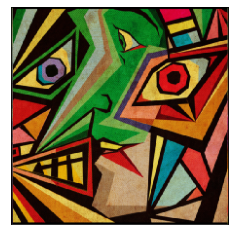

In [ ]:
display_image(preprocess_image(style_image_path))

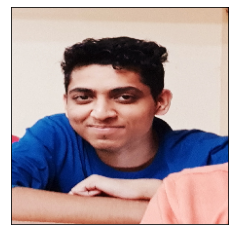

In [ ]:
display_image(preprocess_image(content_image_path))

In [ ]:
content_layer = 'block4_conv2'

content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [ ]:
style_layers = [
    'block1_conv1', 'block2_conv1',
    'block3_conv1', 'block4_conv1',
    'block5_conv1'
    ]

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]
style_layer_wts = [0.2, 0.2, 0.2, 0.2, 0.2]

In [ ]:
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost = tf.reduce_mean(tf.square(C - G))
    return cost

In [ ]:
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G / tf.cast(n, dtype=tf.float32)

In [ ]:
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

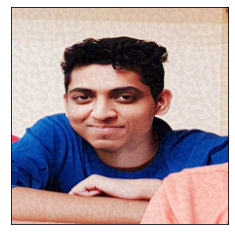

Iteration:1/1000, Total Cost:809391882240.0, Style Cost: 809391.875, Content Cost: 0.0


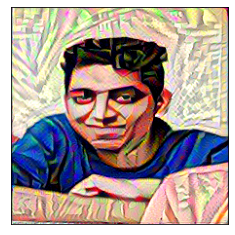

Iteration:101/1000, Total Cost:10520190976.0, Style Cost: 10519.1767578125, Content Cost: 1013452.5625


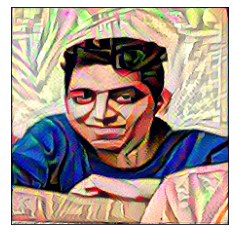

Iteration:201/1000, Total Cost:5765417984.0, Style Cost: 5764.33251953125, Content Cost: 1085652.75


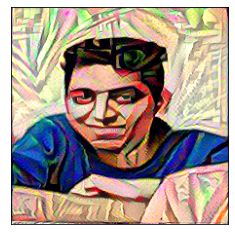

Iteration:301/1000, Total Cost:4255591424.0, Style Cost: 4254.466796875, Content Cost: 1124727.0


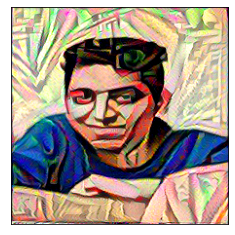

Iteration:401/1000, Total Cost:3493164032.0, Style Cost: 3492.015380859375, Content Cost: 1148757.125


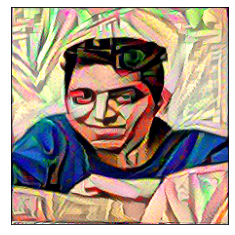

Iteration:501/1000, Total Cost:2999730688.0, Style Cost: 2998.563232421875, Content Cost: 1167242.75


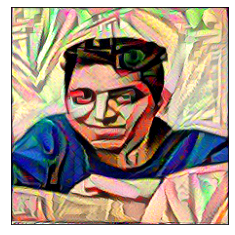

Iteration:601/1000, Total Cost:2655365120.0, Style Cost: 2654.18310546875, Content Cost: 1181967.75


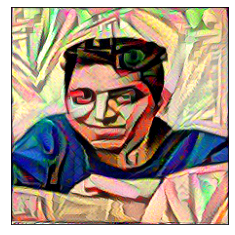

Iteration:701/1000, Total Cost:2407689728.0, Style Cost: 2406.4951171875, Content Cost: 1194514.875


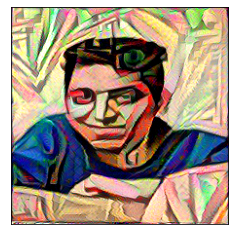

Iteration:801/1000, Total Cost:2217282816.0, Style Cost: 2216.07470703125, Content Cost: 1208110.0


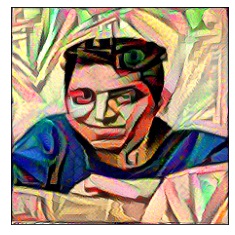

Iteration:901/1000, Total Cost:2031967872.0, Style Cost: 2030.7496337890625, Content Cost: 1218161.375


In [ ]:
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image=generate_noise_image(content_image_preprocessed)
generated_image = tf.Variable(generated_image, dtype=tf.float32)

generated_images = []
costs = []

optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 100 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

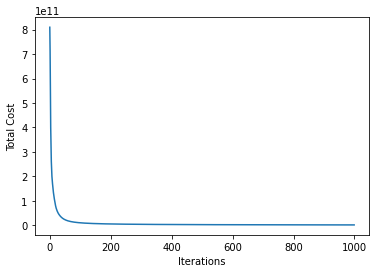

In [ ]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [ ]:
image = Image.fromarray(deprocess(generated_images[-1][0]))
image=image.resize((width_in,height_in))

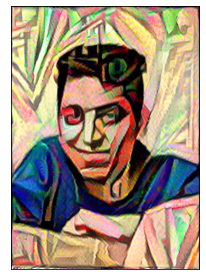

In [ ]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('drive/My Drive/Final4.jpg')